# Projekt 03: Predykcja - Czy skomplikowanie działa?
# Autorzy: Filip Misiak, Adam Kowalczyk
# Data: 2024-11-28

## Importy

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import time
import warnings
warnings.filterwarnings('ignore')

## Ustawienia wykresów

In [ ]:
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## CZĘŚĆ 1: PRZYGOTOWANIE DANYCH

### SCENARIUSZ 1: Idealne warunki dla regresji liniowej


Kształt danych: (20640, 8)
Liczba obserwacji: 20640
Liczba cech: 8

Opis cech:
  1. MedInc
  2. HouseAge
  3. AveRooms
  4. AveBedrms
  5. Population
  6. AveOccup
  7. Latitude
  8. Longitude

Podstawowe statystyki zmiennej docelowej:
count    20640.000000
mean         2.068558
std          1.153956
min          0.149990
25%          1.196000
50%          1.797000
75%          2.647250
max          5.000010
Name: MedHouseVal, dtype: float64

Przed usunięciem outlierów: 20640 obserwacji
Po usunięciu outlierów: 19485 obserwacji (94.4% danych zachowanych)

Usunięte obserwacje:
- IQR (MedHouseVal): 1071
- MedInc > 11: 158
- AveRooms > 30: 24
- AveBedrms > 5: 45
- Population > 10000: 23
- AveOccup > 50: 7

Zbiór treningowy: 15588 obserwacji
Zbiór testowy: 3897 obserwacji


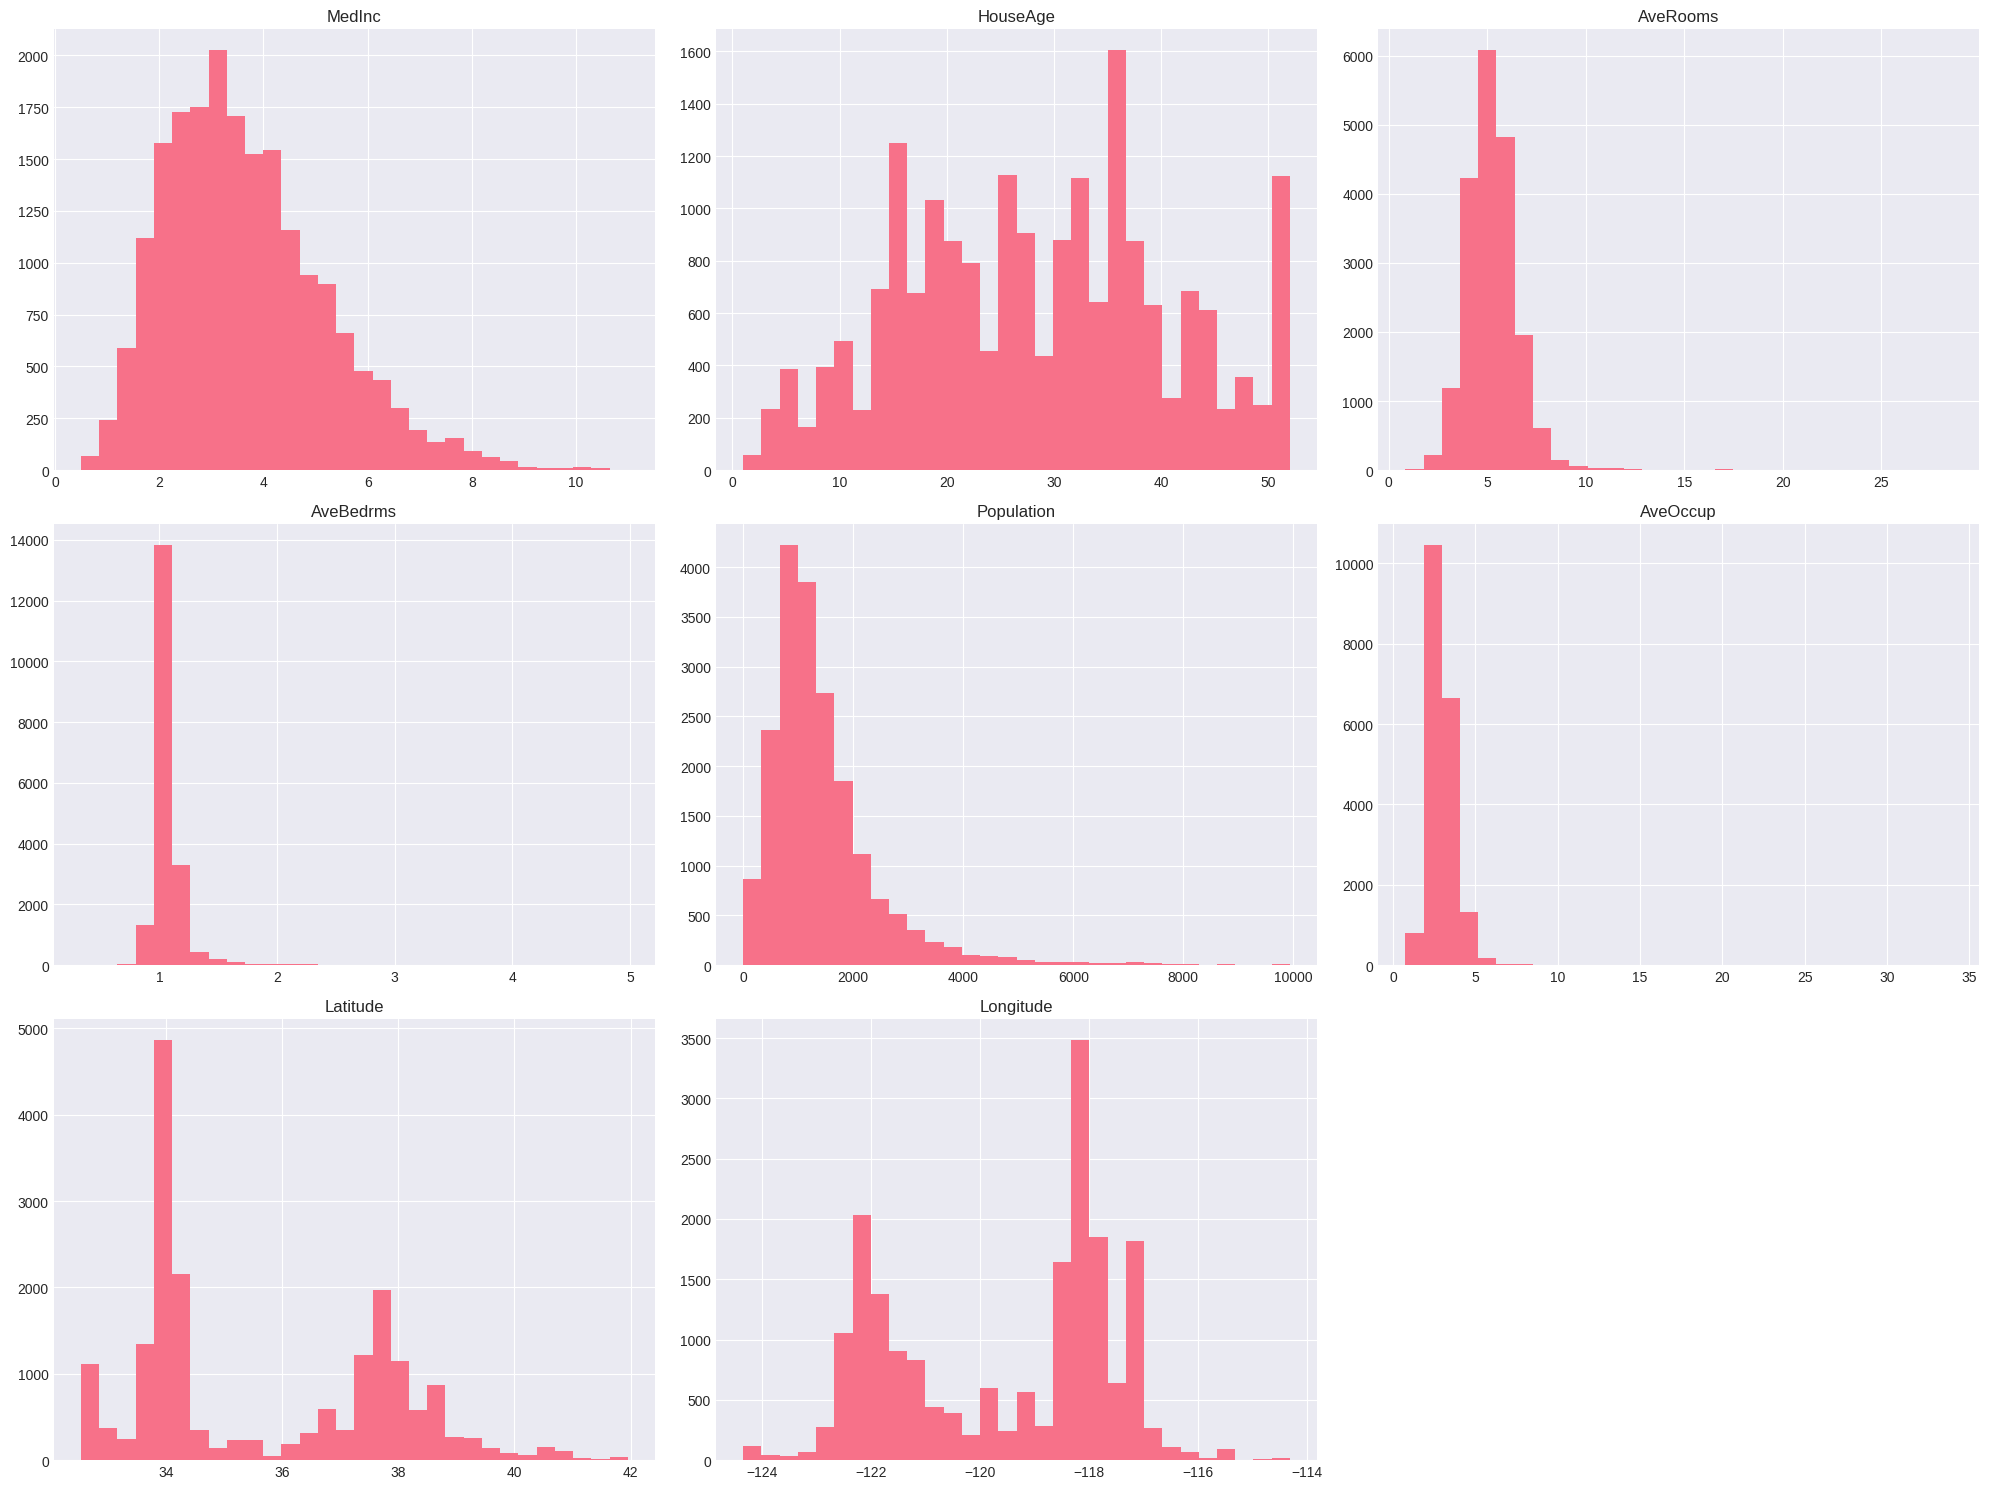

In [ ]:
# Zbiór: California Housing Dataset
# Wczytanie danych California Housing
california = fetch_california_housing()
X_cal = pd.DataFrame(california.data, columns=california.feature_names)
y_cal = pd.Series(california.target, name='MedHouseVal')

print(f"\nKształt danych: {X_cal.shape}")
print(f"Liczba obserwacji: {X_cal.shape[0]}")
print(f"Liczba cech: {X_cal.shape[1]}")
print(f"\nOpis cech:")
for i, name in enumerate(california.feature_names):
    print(f"  {i+1}. {name}")

# Podstawowe statystyki
print("\nPodstawowe statystyki zmiennej docelowej:")
print(y_cal.describe())

# Usunięcie wartości odstających (IQR method dla zmiennej docelowej)
Q1 = y_cal.quantile(0.25)
Q3 = y_cal.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

mask_iqr = (y_cal >= lower_bound) & (y_cal <= upper_bound)

# Usunięcie wartości odstających dla wybranych zmiennych objaśniających
mask_medinc = X_cal['MedInc'] <= 11
mask_averooms = X_cal['AveRooms'] <= 30
mask_avebedrooms = X_cal['AveBedrms'] <= 5
mask_population = X_cal['Population'] <= 10000
mask_aveoccup = X_cal['AveOccup'] <= 50

# Połączenie wszystkich masek
mask_combined = (mask_iqr & mask_medinc & mask_averooms &
                mask_avebedrooms & mask_population & mask_aveoccup)

X_cal_clean = X_cal[mask_combined]
y_cal_clean = y_cal[mask_combined]

print(f"\nPrzed usunięciem outlierów: {X_cal.shape[0]} obserwacji")
print(f"Po usunięciu outlierów: {X_cal_clean.shape[0]} obserwacji ({mask_combined.sum()/len(mask_combined)*100:.1f}% danych zachowanych)")

# Statystyki usuniętych obserwacji
print(f"\nUsunięte obserwacje:")
print(f"- IQR (MedHouseVal): {len(X_cal) - mask_iqr.sum()}")
print(f"- MedInc > 11: {len(X_cal) - mask_medinc.sum()}")
print(f"- AveRooms > 30: {len(X_cal) - mask_averooms.sum()}")
print(f"- AveBedrms > 5: {len(X_cal) - mask_avebedrooms.sum()}")
print(f"- Population > 10000: {len(X_cal) - mask_population.sum()}")
print(f"- AveOccup > 50: {len(X_cal) - mask_aveoccup.sum()}")

# Podział na zbiory treningowy i testowy
X_cal_c_train, X_cal_c_test, y_cal_c_train, y_cal_c_test = train_test_split(
    X_cal_clean, y_cal_clean, test_size=0.2, random_state=42
)

print(f"\nZbiór treningowy: {X_cal_c_train.shape[0]} obserwacji")
print(f"Zbiór testowy: {X_cal_c_test.shape[0]} obserwacji")

# y_cal_clean.hist(figsize=(20, 15), bins=30)
# plt.tight_layout()
# plt.show()

# Wykresy
numeric_cols = X_cal_clean.select_dtypes(include=[np.number]).columns
X_cal_clean[numeric_cols].hist(figsize=(20, 15), bins=30)
plt.tight_layout()
plt.show()

## Scenariusz 1 - dane syntetyczne z deiklatnym szumem


In [ ]:
# Scenariusz 1: Dane syntetyczne - IDEALNIE LINIOWE
from sklearn.datasets import make_regression

X_lin, y_lin = make_regression(
    n_samples=5000,
    n_features=15,
    n_informative=15,
    noise=15,
    bias=50.0,
    random_state=42
)

# Konwersja do DataFrame
feature_names = [f'feature_{i}' for i in range(15)]
X_cal = pd.DataFrame(X_lin, columns=feature_names)
y_cal = pd.Series(y_lin, name='target')

print("SCENARIUSZ 1: Syntetyczne dane liniowe")
print(f"Prawdziwa funkcja: y = β₀ + β₁x₁ + ... + β₁₅x₁₅ + Gaussian_noise(σ=15)")

# Podział na zbiory treningowy i testowy
X_cal_train, X_cal_test, y_cal_train, y_cal_test = train_test_split(
    X_cal, y_cal, test_size=0.2, random_state=42
)

SCENARIUSZ 1: Syntetyczne dane liniowe
Prawdziwa funkcja: y = β₀ + β₁x₁ + ... + β₁₅x₁₅ + Gaussian_noise(σ=15)


### SCENARIUSZ 2: Mały zbiór danych z wieloma cechami

In [ ]:
# wiki_data = pd.read_csv('wiki4HE.csv', sep=';', na_values='?')

# print(f"Przed czyszczeniem: {wiki_data.shape[0]} obserwacji, {wiki_data.shape[1]} zmiennych")

#     # Zastąp brakujące wartości przez 0
# wiki_data_filled = wiki_data.fillna(0)

#     # USUWANIE OBSERWACJI ABY ZOSTAŁO 200
# target_size = 200
# if len(wiki_data_filled) > target_size:
#         # Losowe usunięcie nadmiarowych obserwacji
#         np.random.seed(42)
#         indices_to_keep = np.random.choice(len(wiki_data_filled), target_size, replace=False)
#         wiki_data_reduced = wiki_data_filled.iloc[indices_to_keep].reset_index(drop=True)
#         print(f"Po redukcji do {target_size} obserwacji")
# else:
#         wiki_data_reduced = wiki_data_filled
#         print(f"Zbiór już ma tylko {len(wiki_data_filled)} obserwacji")

#     # PRZYGOTOWANIE ZMIENNYCH
#     # Zmienne demograficzne i kontrolne
# demographic_vars = ['AGE', 'GENDER', 'DOMAIN', 'PhD', 'YEARSEXP', 'UNIVERSITY', 'UOC_POSITION', 'OTHERSTATUS', 'OTHER_POSITION', 'USERWIKI']

#     # Zmienne z ankiet (Likert 1-5)
# survey_vars = [
#         # Perceived Usefulness
#         'PU1', 'PU2', 'PU3',
#         # Perceived Ease of Use
#         'PEU1', 'PEU2', 'PEU3',
#         # Perceived Enjoyment
#         'ENJ1', 'ENJ2',
#         # Quality
#         'Qu1', 'Qu2', 'Qu3', 'Qu4', 'Qu5',
#         # Visibility
#         'Vis1', 'Vis2', 'Vis3',
#         # Social Image
#         'Im1', 'Im2', 'Im3',
#         # Sharing attitude
#         'SA1', 'SA2', 'SA3',
#         # Use behaviour
#         'Use1', 'Use2', 'Use3', 'Use4', 'Use5',
#         # Profile 2.0
#         'Pf1', 'Pf2', 'Pf3',
#         # Job relevance
#         'JR1', 'JR2',
#         # Behavioral intention
#         'BI1', 'BI2',
#         # Incentives
#         'Inc1', 'Inc2', 'Inc3', 'Inc4',
#         # Experience
#         'Exp1', 'Exp2', 'Exp3', 'Exp4', 'Exp5'
#     ]

#     # WYBÓR ZMIENNEJ DOCELOWEJ - kilka opcji:
# target_options = {
#         'Use1': 'Use Wikipedia for teaching materials (1-5)',
#         'BI2': 'Future use intention (1-5)',
#         'PU3': 'Perceived usefulness (1-5)',
#         'YEARSEXP': 'Teaching experience (years)',
#         'AGE': 'Age (years)',
#         'UOC_POSITION': 'Position in university (1-5)',
#         'DOMAIN': 'Domain (1-5)'
#     }

#     # Wybierz zmienną docelową
# target_variable = 'Use1'

# print(f"\nWybrana zmienna docelowa: {target_variable}")
# print(f"Opis: {target_options[target_variable]}")

#     # Przygotowanie cech i zmiennej docelowej
# feature_vars = [var for var in demographic_vars if var != target_variable] + [var for var in survey_vars if var != target_variable]

# X_wiki = wiki_data_reduced[feature_vars]
# y_wiki = wiki_data_reduced[target_variable]

# print(f"\nKształt danych: {X_wiki.shape}")
# print(f"Liczba obserwacji: {X_wiki.shape[0]}")
# print(f"Liczba cech: {X_wiki.shape[1]}")

# print(f"\nPodstawowe statystyki zmiennej docelowej ({target_variable}):")
# print(y_wiki.describe())

# plt.plot(1, 2, 2)
# y_wiki.value_counts().sort_index().plot(kind='bar', alpha=0.7, color='lightcoral')
# plt.title(f'Wartości {target_variable}')
# plt.xlabel('Wartość')
# plt.ylabel('Liczba obserwacji')
# plt.tight_layout()
# plt.show()

#     # ANALIZA KORELACJI
# print(f"\nTop 10 cech najbardziej skorelowanych z {target_variable}:")
# correlations = []
# for col in X_wiki.columns:
#         if pd.api.types.is_numeric_dtype(X_wiki[col]):
#             corr = np.corrcoef(X_wiki[col], y_wiki)[0, 1]
#             correlations.append((col, abs(corr)))

# correlations.sort(key=lambda x: x[1], reverse=True)
# for i, (feature, corr) in enumerate(correlations[:10]):
#         print(f"  {i+1}. {feature}: |r| = {corr:.3f}")

#     # Wybierz najbardziej skorelowane cechy (może poprawić wyniki)
# # top_features = [feature for feature, _ in correlations[:15]]  # top 15 cech

#     # Podział na zbiory treningowy i testowy
# X_wiki_train, X_wiki_test, y_wiki_train, y_wiki_test = train_test_split(
#         X_wiki[feature_vars], y_wiki,
#         test_size=0.2, random_state=42
#     )

# print(f"\nZbiór treningowy: {X_wiki_train.shape[0]} obserwacji")
# print(f"Zbiór testowy: {X_wiki_test.shape[0]} obserwacji")
# print(f"Liczba cech: {X_wiki_train.shape[1]}")


### SCENARIUSZ 3: Silnie nieliniowa zależność

In [ ]:
# Zbiór: Bike Sharing Dataset

# Wczytanie danych Bike Sharing
# Link: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00275/Bike-Sharing-Dataset.zip"

try:
    import urllib.request
    import zipfile
    import io

    # Pobierz i rozpakuj
    response = urllib.request.urlopen(url)
    zip_file = zipfile.ZipFile(io.BytesIO(response.read()))

    # Wczytaj hour.csv (większy zbiór z godzinowymi danymi)
    with zip_file.open('hour.csv') as f:
        bike_data = pd.read_csv(f)

    print("Dane pobrane pomyślnie")

except Exception as e:
    print(f"Nie udało się pobrać danych: {e}")

# Przygotowanie danych Bike Sharing
# Rzeczywiste dane
features_bike = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday',
                  'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
X_bike = bike_data[features_bike]
y_bike = bike_data['cnt']
print(f"\nKształt danych: {X_bike.shape}")
print(f"Liczba obserwacji: {X_bike.shape[0]}")
print(f"Liczba cech: {X_bike.shape[1]}")

print(f"\nPodstawowe statystyki zmiennej docelowej:")
print(y_bike.describe())

# Podział na zbiory
X_bike_train, X_bike_test, y_bike_train, y_bike_test = train_test_split(
    X_bike, y_bike, test_size=0.2, random_state=42
)

print(f"Zbiór treningowy: {X_bike_train.shape[0]} obserwacji")
print(f"Zbiór testowy: {X_bike_test.shape[0]} obserwacji")

Dane pobrane pomyślnie

Kształt danych: (17379, 12)
Liczba obserwacji: 17379
Liczba cech: 12

Podstawowe statystyki zmiennej docelowej:
count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64
Zbiór treningowy: 13903 obserwacji
Zbiór testowy: 3476 obserwacji


## CZĘŚĆ 2: DEFINICJA MODELI I HIPERPARAMETRÓW

In [ ]:
# Definicja modeli z Pipeline
models_config = {
    'Linear Regression': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', LinearRegression())
        ]),
        'params': {}
    },
    'Ridge': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Ridge())
        ]),
        'params': {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'Lasso': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', Lasso(max_iter=5000))
        ]),
        'params': {
            'regressor__alpha': [0.01, 0.1, 1.0, 10.0, 100.0]
        }
    },
    'ElasticNet': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', ElasticNet(max_iter=5000))
        ]),
        'params': {
            'regressor__alpha': [0.1, 1.0, 10.0],
            'regressor__l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'Polynomial (degree=2)': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=2, include_bias=False)),
            ('regressor', Ridge())
        ]),
        'params': {
            'regressor__alpha': [0.1, 1.0, 10.0, 100.0]
        }
    },
    'Polynomial (degree=3)': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('poly', PolynomialFeatures(degree=3, include_bias=False)),
            ('regressor', Ridge())
        ]),
        'params': {
            'regressor__alpha': [1.0, 10.0, 100.0]
        }
    },
    'SVR (linear)': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', SVR(kernel='linear', cache_size=1000))
        ]),
        'params': {
            'regressor__C': [1.0, 10.0],
            'regressor__epsilon': [0.1]
        }
    },
    'SVR (RBF)': {
        'model': Pipeline([
            ('scaler', StandardScaler()),
            ('regressor', SVR(kernel='rbf', cache_size=1000))
        ]),
        'params': {
            'regressor__C': [1.0, 10.0],
            'regressor__gamma': ['scale', 0.1],
            'regressor__epsilon': [0.1]
            }
    },
    'Random Forest': {
        'model': RandomForestRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [100],
            'max_depth': [20, None],
            'min_samples_split': [2, 10]
        }
    },
    'XGBoost': {
        'model': xgb.XGBRegressor(random_state=42, n_jobs=-1),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.3],
            'subsample': [0.8, 1.0]
        }
    }
}

print("\nLista modeli do porównania:")
for i, name in enumerate(models_config.keys(), 1):
    print(f"  {i}. {name}")


Lista modeli do porównania:
  1. Linear Regression
  2. Ridge
  3. Lasso
  4. ElasticNet
  5. Polynomial (degree=2)
  6. Polynomial (degree=3)
  7. SVR (linear)
  8. SVR (RBF)
  9. Random Forest
  10. XGBoost


## CZĘŚĆ 3: FUNKCJE POMOCNICZE

In [ ]:
def train_and_evaluate_model(name, model, param_grid, X_train, y_train, X_test, y_test):
    """
    Trenuje model z tunningiem hiperparametrów i zwraca wyniki.
    """
    print(f"\n{'='*60}")
    print(f"Trenowanie: {name}")
    print(f"{'='*60}")

    results = {
        'name': name,
        'best_params': None,
        'train_time': 0,
        'predict_time': 0,
        'mse': 0,
        'rmse': 0,
        'mae': 0,
        'r2': 0,
        'cv_score': 0
    }

    try:
        # SVR nie skaluje się dobrze - używamy subsampleingu dla dużych zbiorów
        X_train_use = X_train
        y_train_use = y_train

        if 'SVR' in name and len(X_train) > 5000:
            print(f"  SVR nie skaluje się dobrze dla dużych zbiorów")
            print(f"  Używam 5000 losowych próbek zamiast {len(X_train)} (subsampling)")

            np.random.seed(42)
            indices = np.random.choice(len(X_train), 5000, replace=False)

            if isinstance(X_train, pd.DataFrame):
                X_train_use = X_train.iloc[indices]
                y_train_use = y_train.iloc[indices]
            else:
                X_train_use = X_train[indices]
                y_train_use = y_train[indices]

        # Tuning hiperparametrów
        start_train = time.time()

        if param_grid:
            # GridSearchCV dla małych przestrzeni, RandomizedSearchCV dla dużych
            n_combinations = np.prod([len(v) for v in param_grid.values()])

            if n_combinations <= 50:
                print(f"Grid Search CV ({n_combinations} kombinacji)")
                search = GridSearchCV(
                    model, param_grid, cv=3, scoring='neg_mean_squared_error',
                    n_jobs=-1, verbose=0
                )
            else:
                from sklearn.model_selection import RandomizedSearchCV
                print(f"Randomized Search CV (30 z {n_combinations} kombinacji)")
                search = RandomizedSearchCV(
                    model, param_grid, n_iter=30, cv=3, scoring='neg_mean_squared_error',
                    n_jobs=-1, verbose=0, random_state=42
                )

            search.fit(X_train_use, y_train_use)
            best_model = search.best_estimator_
            results['best_params'] = search.best_params_
            results['cv_score'] = -search.best_score_

            print(f"Najlepsze parametry: {search.best_params_}")
            print(f"CV MSE: {-search.best_score_:.3f}")
        else:
            # Brak tuningu - trening bezpośredni
            print("Trening bez tuningu hiperparametrów")
            model.fit(X_train_use, y_train_use)
            best_model = model

            # CV score
            cv_scores = cross_val_score(
                model, X_train_use, y_train_use, cv=3,
                scoring='neg_mean_squared_error', n_jobs=-1
            )
            results['cv_score'] = -cv_scores.mean()
            print(f"CV MSE: {-cv_scores.mean():.3f}")

        train_time = time.time() - start_train
        results['train_time'] = train_time
        print(f"Czas trenowania: {train_time:.3f}s")

        # Predykcja
        start_predict = time.time()
        y_pred = best_model.predict(X_test)
        predict_time = time.time() - start_predict
        results['predict_time'] = predict_time

        # Metryki
        results['mse'] = mean_squared_error(y_test, y_pred)
        results['rmse'] = np.sqrt(results['mse'])
        results['mae'] = mean_absolute_error(y_test, y_pred)
        results['r2'] = r2_score(y_test, y_pred)

        print(f"Czas predykcji: {predict_time:.3f}s")
        print(f"MSE: {results['mse']:.3f}")
        print(f"RMSE: {results['rmse']:.3f}")
        print(f"MAE: {results['mae']:.3f}")
        print(f"R²: {results['r2']:.3f}")

        return results, best_model

    except Exception as e:
        print(f"BŁĄD: {str(e)}")
        results['error'] = str(e)
        return results, None

In [ ]:
def compare_scenarios(results_scenario1, results_scenario2, scenario1_name, scenario2_name):

    # Konwersja do DataFrame
    df1 = pd.DataFrame(results_scenario1)
    df2 = pd.DataFrame(results_scenario2)

    # Wykres 1: Porównanie R² score
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Scenariusz 1
    df1_sorted = df1.sort_values('r2', ascending=True)
    axes[0].barh(df1_sorted['name'], df1_sorted['r2'], color='steelblue')
    axes[0].set_xlabel('R² Score', fontsize=12)
    axes[0].set_title(f'{scenario1_name}\nR² Score (wyższy = lepszy)', fontsize=14, fontweight='bold')
    axes[0].axvline(x=0.9, color='green', linestyle='--', alpha=0.5, label='Dobry próg (0.9)')
    axes[0].legend()
    axes[0].grid(axis='x', alpha=0.3)

    # Scenariusz 2
    df2_sorted = df2.sort_values('r2', ascending=True)
    axes[1].barh(df2_sorted['name'], df2_sorted['r2'], color='coral')
    axes[1].set_xlabel('R² Score', fontsize=12)
    axes[1].set_title(f'{scenario2_name}\nR² Score (wyższy = lepszy)', fontsize=14, fontweight='bold')
    axes[1].axvline(x=0.9, color='green', linestyle='--', alpha=0.5, label='Dobry próg (0.9)')
    axes[1].legend()
    axes[1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('comparison_r2_score.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Wykres 2: Porównanie RMSE
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Scenariusz 1
    df1_sorted = df1.sort_values('rmse', ascending=False)
    axes[0].barh(df1_sorted['name'], df1_sorted['rmse'], color='steelblue')
    axes[0].set_xlabel('RMSE', fontsize=12)
    axes[0].set_title(f'{scenario1_name}\nRMSE (niższy = lepszy)', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

    # Scenariusz 2
    df2_sorted = df2.sort_values('rmse', ascending=False)
    axes[1].barh(df2_sorted['name'], df2_sorted['rmse'], color='coral')
    axes[1].set_xlabel('RMSE', fontsize=12)
    axes[1].set_title(f'{scenario2_name}\nRMSE (niższy = lepszy)', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('comparison_rmse.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Wykres 3: Trade-off wydajność vs czas
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Scenariusz 1
    scatter1 = axes[0].scatter(df1['train_time'], df1['r2'],
                               s=200, alpha=0.6, c=df1['r2'],
                               cmap='RdYlGn', edgecolors='black', linewidth=1.5)
    for idx, row in df1.iterrows():
        axes[0].annotate(row['name'], (row['train_time'], row['r2']),
                        fontsize=8, ha='right', va='bottom')
    axes[0].set_xlabel('Czas trenowania (s)', fontsize=12)
    axes[0].set_ylabel('R² Score', fontsize=12)
    axes[0].set_title(f'{scenario1_name}\nTrade-off: Wydajność vs Czas',
                     fontsize=14, fontweight='bold')
    axes[0].grid(alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0], label='R² Score')

    # Scenariusz 2
    scatter2 = axes[1].scatter(df2['train_time'], df2['r2'],
                               s=200, alpha=0.6, c=df2['r2'],
                               cmap='RdYlGn', edgecolors='black', linewidth=1.5)
    for idx, row in df2.iterrows():
        axes[1].annotate(row['name'], (row['train_time'], row['r2']),
                        fontsize=8, ha='right', va='bottom')
    axes[1].set_xlabel('Czas trenowania (s)', fontsize=12)
    axes[1].set_ylabel('R² Score', fontsize=12)
    axes[1].set_title(f'{scenario2_name}\nTrade-off: Wydajność vs Czas',
                     fontsize=14, fontweight='bold')
    axes[1].grid(alpha=0.3)
    plt.colorbar(scatter2, ax=axes[1], label='R² Score')

    plt.tight_layout()
    plt.savefig('comparison_tradeoff.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Wykres 4: Czas predykcji
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    df1_sorted = df1.sort_values('predict_time', ascending=True)
    axes[0].barh(df1_sorted['name'], df1_sorted['predict_time'] * 1000, color='steelblue')
    axes[0].set_xlabel('Czas predykcji (ms)', fontsize=12)
    axes[0].set_title(f'{scenario1_name}\nCzas predykcji', fontsize=14, fontweight='bold')
    axes[0].grid(axis='x', alpha=0.3)

    df2_sorted = df2.sort_values('predict_time', ascending=True)
    axes[1].barh(df2_sorted['name'], df2_sorted['predict_time'] * 1000, color='coral')
    axes[1].set_xlabel('Czas predykcji (ms)', fontsize=12)
    axes[1].set_title(f'{scenario2_name}\nCzas predykcji', fontsize=14, fontweight='bold')
    axes[1].grid(axis='x', alpha=0.3)

    plt.tight_layout()
    plt.savefig('comparison_predict_time.png', dpi=300, bbox_inches='tight')
    plt.show()

## CZĘŚĆ 4: TRENOWANIE MODELI - SCENARIUSZ 1

### SCENARIUSZ 1 (California Housing)

In [ ]:
results_scenario1_c = []
models_scenario1_c = {}

for name, config in models_config.items():
    result, trained_model = train_and_evaluate_model(
        name,
        config['model'],
        config['params'],
        X_cal_c_train, y_cal_c_train,
        X_cal_c_test, y_cal_c_test
    )
    results_scenario1_c.append(result)
    models_scenario1_c[name] = trained_model

# Tabela podsumowująca - Scenariusz 1

df_results1 = pd.DataFrame(results_scenario1_c)
df_results1 = df_results1.sort_values('r2', ascending=False)

print("\n" + df_results1[['name', 'mse', 'rmse', 'mae', 'r2', 'train_time', 'predict_time']].to_string(index=False))


Trenowanie: Linear Regression
Trening bez tuningu hiperparametrów
CV MSE: 0.350
Czas trenowania: 0.151s
Czas predykcji: 0.003s
MSE: 0.347
RMSE: 0.589
MAE: 0.434
R²: 0.628

Trenowanie: Ridge
Grid Search CV (5 kombinacji)
Najlepsze parametry: {'regressor__alpha': 1.0}
CV MSE: 0.350
Czas trenowania: 0.360s
Czas predykcji: 0.003s
MSE: 0.347
RMSE: 0.589
MAE: 0.434
R²: 0.628

Trenowanie: Lasso
Grid Search CV (5 kombinacji)
Najlepsze parametry: {'regressor__alpha': 0.01}
CV MSE: 0.354
Czas trenowania: 0.343s
Czas predykcji: 0.003s
MSE: 0.354
RMSE: 0.595
MAE: 0.439
R²: 0.620

Trenowanie: ElasticNet
Grid Search CV (9 kombinacji)
Najlepsze parametry: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.3}
CV MSE: 0.421
Czas trenowania: 0.419s
Czas predykcji: 0.002s
MSE: 0.431
RMSE: 0.657
MAE: 0.496
R²: 0.537

Trenowanie: Polynomial (degree=2)
Grid Search CV (4 kombinacji)
Najlepsze parametry: {'regressor__alpha': 10.0}
CV MSE: 0.299
Czas trenowania: 0.330s
Czas predykcji: 0.005s
MSE: 0.295
RMSE: 

In [ ]:
results_scenario1 = []
models_scenario1 = {}

for name, config in models_config.items():
    result, trained_model = train_and_evaluate_model(
        name,
        config['model'],
        config['params'],
        X_cal_train, y_cal_train,
        X_cal_test, y_cal_test
    )
    results_scenario1.append(result)
    models_scenario1[name] = trained_model

# Tabela podsumowująca - Scenariusz 1

df_results1 = pd.DataFrame(results_scenario1)
df_results1 = df_results1.sort_values('r2', ascending=False)

print("\n" + df_results1[['name', 'mse', 'rmse', 'mae', 'r2', 'train_time', 'predict_time']].to_string(index=False))


Trenowanie: Linear Regression
Trening bez tuningu hiperparametrów
CV MSE: 228.274
Czas trenowania: 0.074s
Czas predykcji: 0.003s
MSE: 229.313
RMSE: 15.143
MAE: 12.164
R²: 0.995

Trenowanie: Ridge
Grid Search CV (5 kombinacji)
Najlepsze parametry: {'regressor__alpha': 0.1}
CV MSE: 228.273
Czas trenowania: 0.206s
Czas predykcji: 0.002s
MSE: 229.307
RMSE: 15.143
MAE: 12.164
R²: 0.995

Trenowanie: Lasso
Grid Search CV (5 kombinacji)
Najlepsze parametry: {'regressor__alpha': 0.01}
CV MSE: 228.275
Czas trenowania: 0.156s
Czas predykcji: 0.002s
MSE: 229.270
RMSE: 15.142
MAE: 12.164
R²: 0.995

Trenowanie: ElasticNet
Grid Search CV (9 kombinacji)
Najlepsze parametry: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.7}
CV MSE: 267.036
Czas trenowania: 0.272s
Czas predykcji: 0.003s
MSE: 261.018
RMSE: 16.156
MAE: 12.957
R²: 0.994

Trenowanie: Polynomial (degree=2)
Grid Search CV (4 kombinacji)
Najlepsze parametry: {'regressor__alpha': 1.0}
CV MSE: 239.290
Czas trenowania: 0.293s
Czas predykcji:

### SCENARIUSZ 2 (wiki4HE)

In [ ]:
# results_scenario2 = []
# models_scenario2 = {}

# for name, config in models_config.items():
#     result, trained_model = train_and_evaluate_model(
#         name,
#         config['model'],
#         config['params'],
#         X_wiki_train, y_wiki_train, X_wiki_test, y_wiki_test
#     )
#     results_scenario2.append(result)
#     models_scenario2[name] = trained_model

# df_results2 = pd.DataFrame(results_scenario2)
# df_results2 = df_results2.sort_values('r2', ascending=False)
# print("\nSCENARIUSZ 2 - Geographical Origin of Music:")
# print(df_results2[['name', 'mse', 'rmse', 'mae', 'r2', 'train_time', 'predict_time']].to_string(index=False))

### SCENARIUSZ 3 (Bike Sharing)

In [ ]:
results_scenario3 = []
models_scenario3 = {}

for name, config in models_config.items():
    result, trained_model = train_and_evaluate_model(
        name,
        config['model'],
        config['params'],
        X_bike_train, y_bike_train,
        X_bike_test, y_bike_test
    )
    results_scenario3.append(result)
    models_scenario3[name] = trained_model

# Tabela podsumowująca - Scenariusz 3

df_results3 = pd.DataFrame(results_scenario3)
df_results3 = df_results3.sort_values('r2', ascending=False)

print("\n" + df_results3[['name', 'mse', 'rmse', 'mae', 'r2', 'train_time', 'predict_time']].to_string(index=False))


Trenowanie: Linear Regression
Trening bez tuningu hiperparametrów
CV MSE: 20323.519
Czas trenowania: 0.081s
Czas predykcji: 0.003s
MSE: 19379.828
RMSE: 139.211
MAE: 104.803
R²: 0.388

Trenowanie: Ridge
Grid Search CV (5 kombinacji)
Najlepsze parametry: {'regressor__alpha': 10.0}
CV MSE: 20323.377
Czas trenowania: 0.236s
Czas predykcji: 0.002s
MSE: 19380.066
RMSE: 139.212
MAE: 104.801
R²: 0.388

Trenowanie: Lasso
Grid Search CV (5 kombinacji)
Najlepsze parametry: {'regressor__alpha': 0.1}
CV MSE: 20323.203
Czas trenowania: 0.473s
Czas predykcji: 0.003s
MSE: 19379.447
RMSE: 139.210
MAE: 104.775
R²: 0.388

Trenowanie: ElasticNet
Grid Search CV (9 kombinacji)
Najlepsze parametry: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.7}
CV MSE: 20328.943
Czas trenowania: 0.562s
Czas predykcji: 0.003s
MSE: 19382.295
RMSE: 139.220
MAE: 104.695
R²: 0.388

Trenowanie: Polynomial (degree=2)
Grid Search CV (4 kombinacji)
Najlepsze parametry: {'regressor__alpha': 100.0}
CV MSE: 15063.088
Czas trenow

## CZĘŚĆ 5: WIZUALIZACJA PORÓWNAWCZA

## Scanariusz 1 - porównanie zbioru California housing ze zbiorem syntetycznym

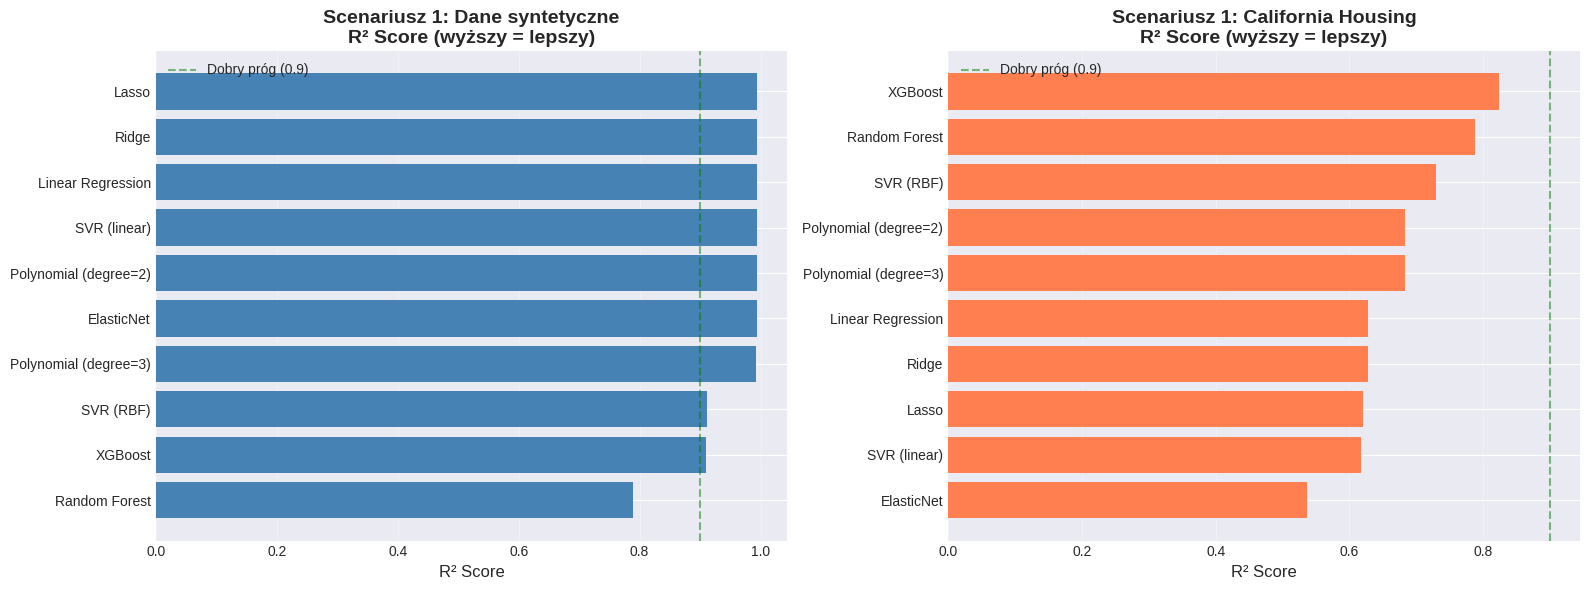

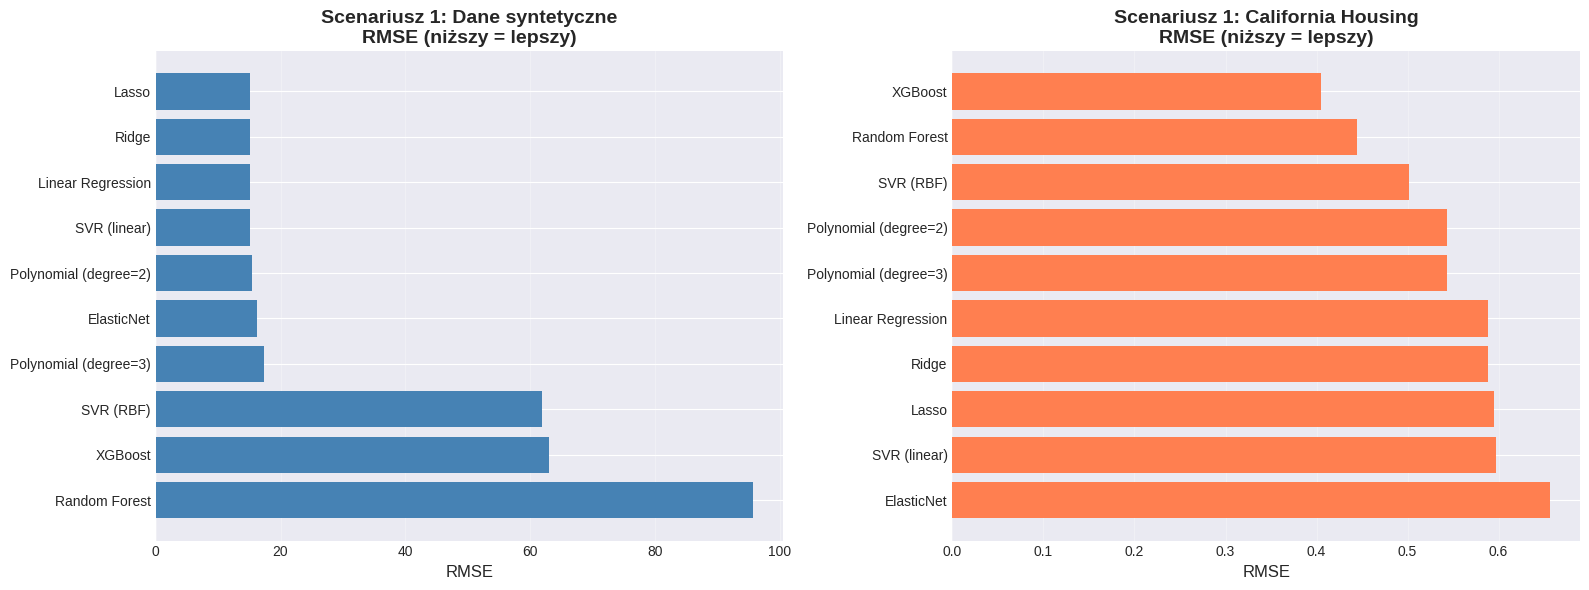

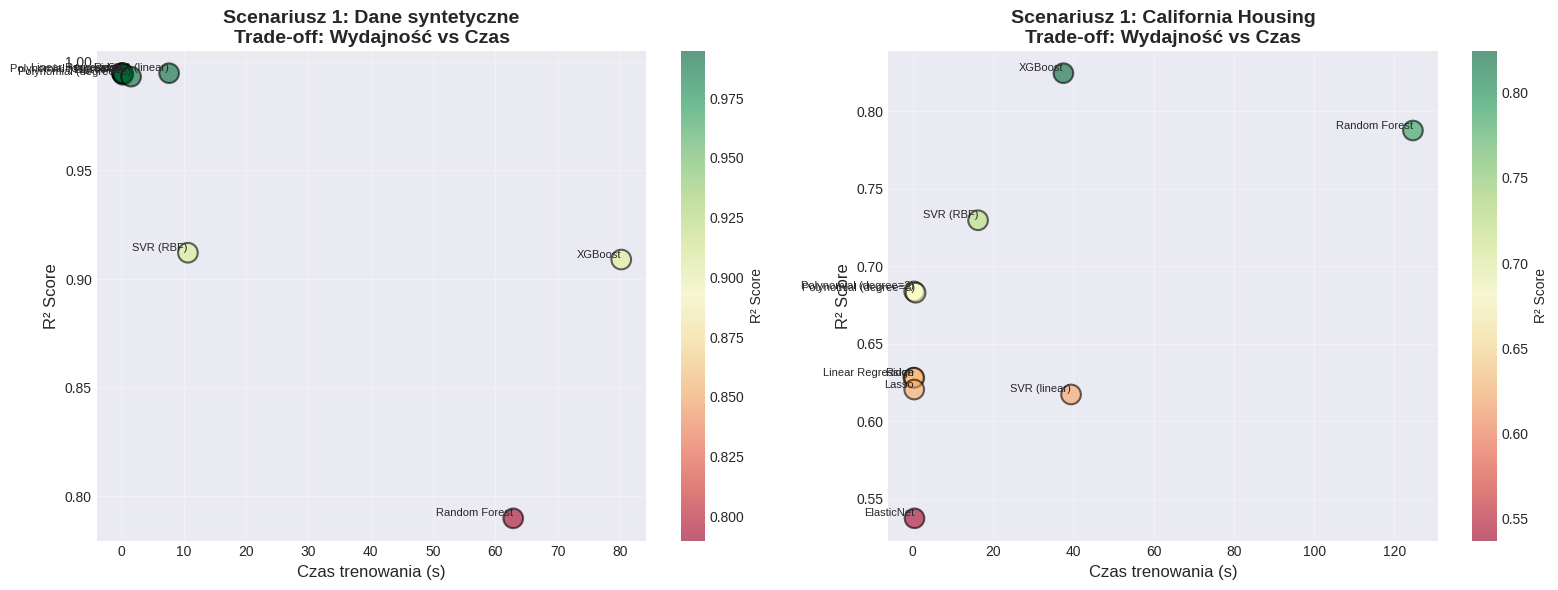

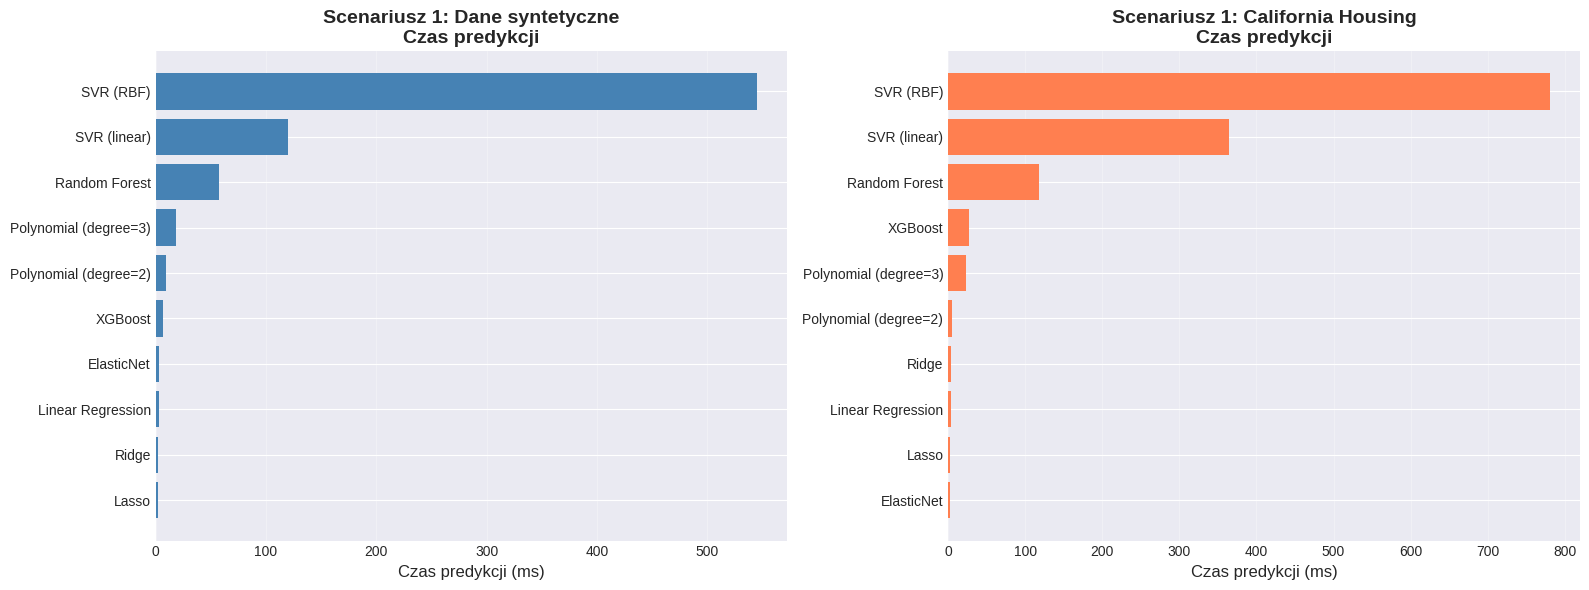

In [ ]:
compare_scenarios(results_scenario1, results_scenario1_c,
                 "Scenariusz 1: Dane syntetyczne",
                  "Scenariusz 1: California Housing",)

## Porównanie obu scneariuszy

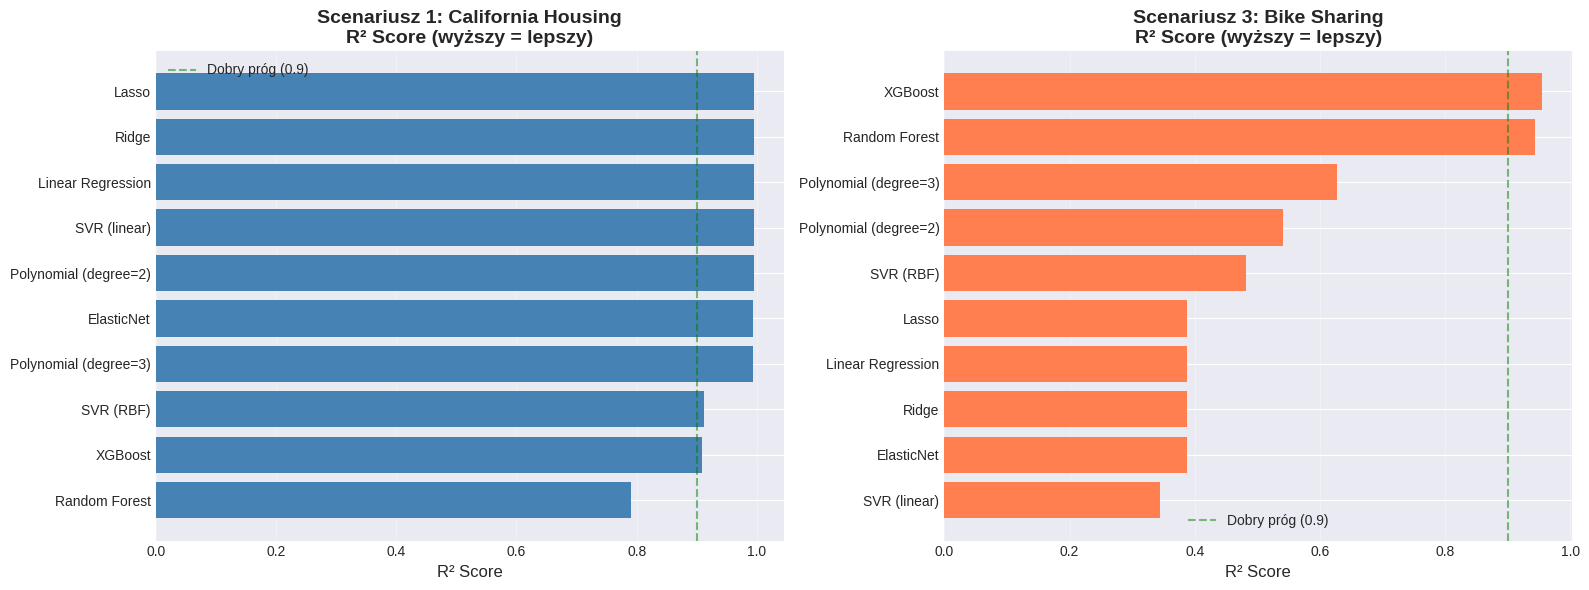

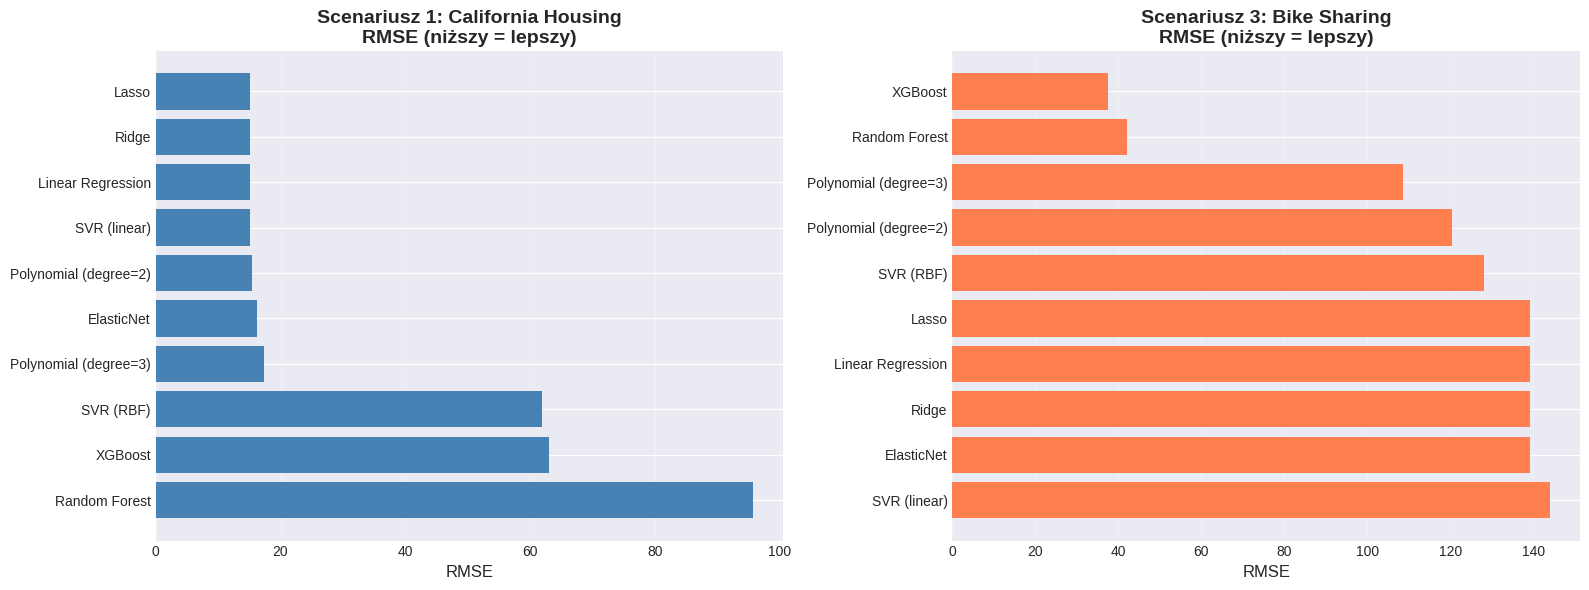

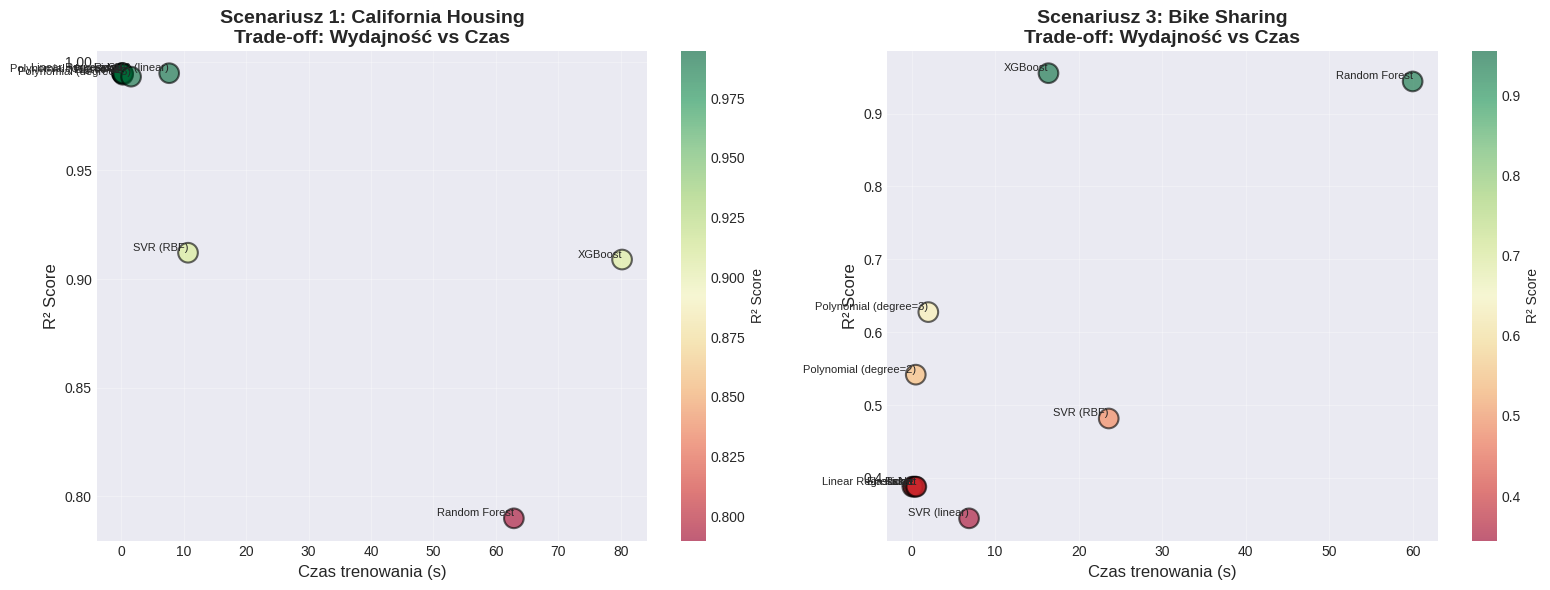

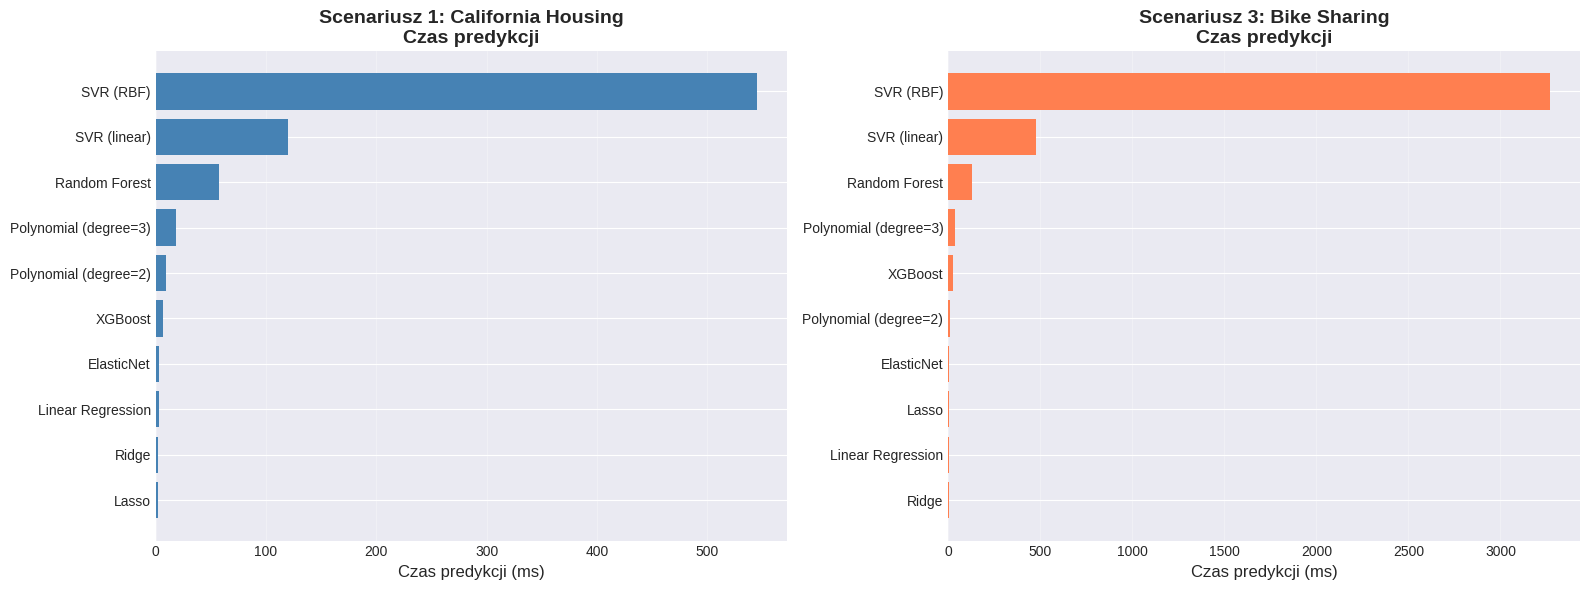

In [ ]:
compare_scenarios(results_scenario1, results_scenario3,
                 "Scenariusz 1: California Housing",
                 "Scenariusz 3: Bike Sharing")

# compare_three_scenarios(results_scenario1, results_scenario2, results_scenario3,
#                        "Scenariusz 1: California Housing",
#                        "Scenariusz 2: Geographical Origin of Music",
#                        "Scenariusz 3: Bike Sharing")

## CZĘŚĆ 7: EKSPERYMENT - 10X MNIEJSZY ZBIÓR TRENINGOWY

Scenariusz 1 (California Housing) - 10x mniejszy zbiór
Oryginalny zbiór: 4000 obserwacji
Zmniejszony zbiór: 400 obserwacji

Trenowanie: Linear Regression (10x mniejszy)
Trening bez tuningu hiperparametrów
CV MSE: 205.656
Czas trenowania: 0.060s
Czas predykcji: 0.002s
MSE: 241.988
RMSE: 15.556
MAE: 12.508
R²: 0.994

Trenowanie: Ridge (10x mniejszy)
Grid Search CV (5 kombinacji)
Najlepsze parametry: {'regressor__alpha': 0.1}
CV MSE: 205.654
Czas trenowania: 0.138s
Czas predykcji: 0.002s
MSE: 241.855
RMSE: 15.552
MAE: 12.505
R²: 0.994

Trenowanie: Lasso (10x mniejszy)
Grid Search CV (5 kombinacji)
Najlepsze parametry: {'regressor__alpha': 0.01}
CV MSE: 205.667
Czas trenowania: 0.204s
Czas predykcji: 0.002s
MSE: 241.904
RMSE: 15.553
MAE: 12.506
R²: 0.994

Trenowanie: Polynomial (degree=2) (10x mniejszy)
Grid Search CV (4 kombinacji)
Najlepsze parametry: {'regressor__alpha': 1.0}
CV MSE: 422.894
Czas trenowania: 0.136s
Czas predykcji: 0.005s
MSE: 360.533
RMSE: 18.988
MAE: 15.006
R²: 0.992



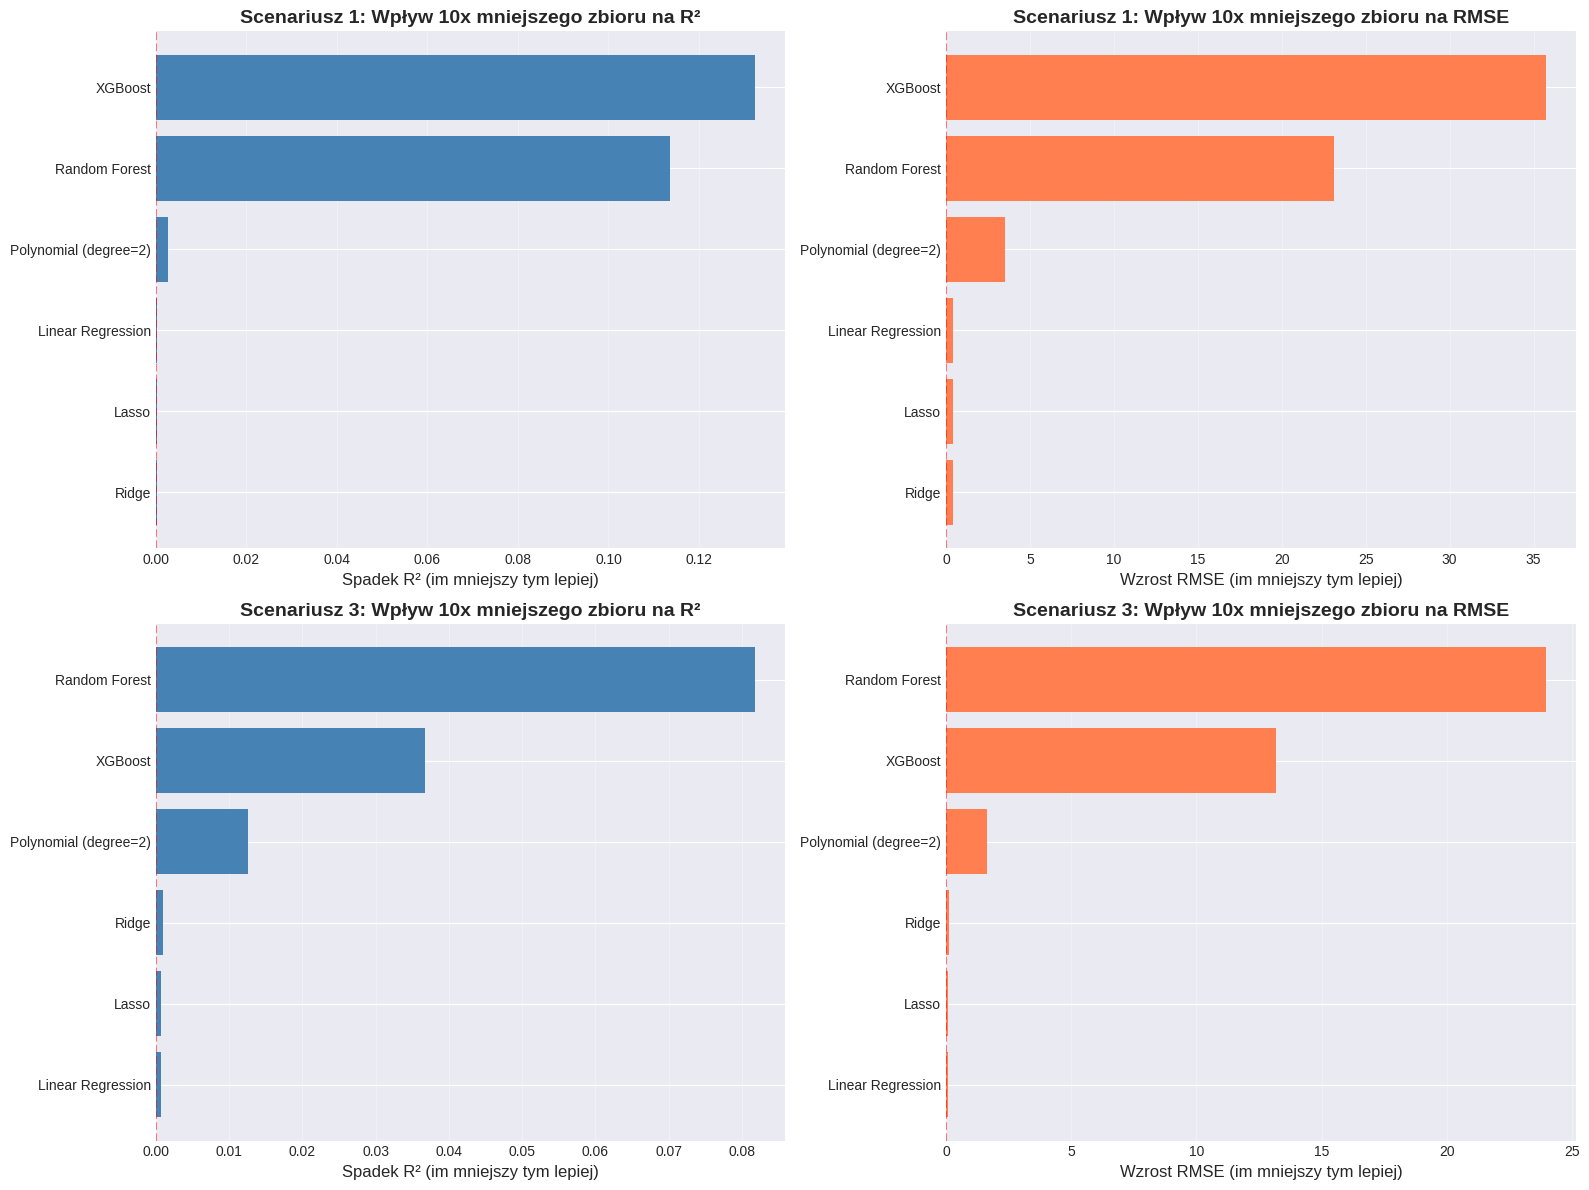

In [ ]:
# Scenariusz 1 - 10x mniejszy zbiór
print("Scenariusz 1 (California Housing) - 10x mniejszy zbiór")

n_small = len(X_cal_train) // 10
print(f"Oryginalny zbiór: {len(X_cal_train)} obserwacji")
print(f"Zmniejszony zbiór: {n_small} obserwacji")

np.random.seed(42)
small_indices_cal = np.random.choice(len(X_cal_train), n_small, replace=False)

if isinstance(X_cal_train, pd.DataFrame):
    X_cal_train_small = X_cal_train.iloc[small_indices_cal]
    y_cal_train_small = y_cal_train.iloc[small_indices_cal]
else:
    X_cal_train_small = X_cal_train[small_indices_cal]
    y_cal_train_small = y_cal_train[small_indices_cal]

# Wybrane modele do porównania (szybkie + różne typy)
models_small_test = {
    'Linear Regression': models_config['Linear Regression'],
    'Ridge': models_config['Ridge'],
    'Lasso': models_config['Lasso'],
    'Polynomial (degree=2)': models_config['Polynomial (degree=2)'],
    'Random Forest': models_config['Random Forest'],
    'XGBoost': models_config['XGBoost']
}

results_small_cal = []
for name, config in models_small_test.items():
    result, _ = train_and_evaluate_model(
        name + " (10x mniejszy)",
        config['model'],
        config['params'],
        X_cal_train_small, y_cal_train_small,
        X_cal_test, y_cal_test
    )
    results_small_cal.append(result)

print("\n" + "="*60)
print("PORÓWNANIE: Pełny zbiór vs 10x mniejszy (Scenariusz 1)")
print("="*60)

# Porównanie wyników
comparison_cal = []
for original in results_scenario1:
    if original['name'] in [m.replace(" (10x mniejszy)", "") for m in [r['name'] for r in results_small_cal]]:
        small = next((r for r in results_small_cal if r['name'].replace(" (10x mniejszy)", "") == original['name']), None)
        if small:
            comparison_cal.append({
                'Model': original['name'],
                'R² (pełny)': original['r2'],
                'R² (10x mniejszy)': small['r2'],
                'Δ R²': original['r2'] - small['r2'],
                'RMSE (pełny)': original['rmse'],
                'RMSE (10x mniejszy)': small['rmse'],
                'Δ RMSE': small['rmse'] - original['rmse']
            })

df_comparison_cal = pd.DataFrame(comparison_cal)
print("\n" + df_comparison_cal.to_string(index=False))

# Scenariusz 3 - 10x mniejszy zbiór
print("Scenariusz 3 (Bike Sharing) - 10x mniejszy zbiór")

n_small_bike = len(X_bike_train) // 10
print(f"Oryginalny zbiór: {len(X_bike_train)} obserwacji")
print(f"Zmniejszony zbiór: {n_small_bike} obserwacji")

np.random.seed(42)
small_indices_bike = np.random.choice(len(X_bike_train), n_small_bike, replace=False)

if isinstance(X_bike_train, pd.DataFrame):
    X_bike_train_small = X_bike_train.iloc[small_indices_bike]
    y_bike_train_small = y_bike_train.iloc[small_indices_bike]
else:
    X_bike_train_small = X_bike_train[small_indices_bike]
    y_bike_train_small = y_bike_train[small_indices_bike]

results_small_bike = []
for name, config in models_small_test.items():
    result, _ = train_and_evaluate_model(
        name + " (10x mniejszy)",
        config['model'],
        config['params'],
        X_bike_train_small, y_bike_train_small,
        X_bike_test, y_bike_test
    )
    results_small_bike.append(result)

print("\n" + "="*60)
print("PORÓWNANIE: Pełny zbiór vs 10x mniejszy (Scenariusz 3)")
print("="*60)

# Porównanie wyników
comparison_bike = []
for original in results_scenario3:
    if original['name'] in [m.replace(" (10x mniejszy)", "") for m in [r['name'] for r in results_small_bike]]:
        small = next((r for r in results_small_bike if r['name'].replace(" (10x mniejszy)", "") == original['name']), None)
        if small:
            comparison_bike.append({
                'Model': original['name'],
                'R² (pełny)': original['r2'],
                'R² (10x mniejszy)': small['r2'],
                'Δ R²': original['r2'] - small['r2'],
                'RMSE (pełny)': original['rmse'],
                'RMSE (10x mniejszy)': small['rmse'],
                'Δ RMSE': small['rmse'] - original['rmse']
            })

df_comparison_bike = pd.DataFrame(comparison_bike)
print("\n" + df_comparison_bike.to_string(index=False))

# Wizualizacja porównania
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Scenariusz 1 - R²
df_comp_cal = df_comparison_cal.sort_values('Δ R²')
axes[0, 0].barh(df_comp_cal['Model'], df_comp_cal['Δ R²'], color='steelblue')
axes[0, 0].set_xlabel('Spadek R² (im mniejszy tym lepiej)', fontsize=12)
axes[0, 0].set_title('Scenariusz 1: Wpływ 10x mniejszego zbioru na R²', fontsize=14, fontweight='bold')
axes[0, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 0].grid(axis='x', alpha=0.3)

# Scenariusz 1 - RMSE
axes[0, 1].barh(df_comp_cal['Model'], df_comp_cal['Δ RMSE'], color='coral')
axes[0, 1].set_xlabel('Wzrost RMSE (im mniejszy tym lepiej)', fontsize=12)
axes[0, 1].set_title('Scenariusz 1: Wpływ 10x mniejszego zbioru na RMSE', fontsize=14, fontweight='bold')
axes[0, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[0, 1].grid(axis='x', alpha=0.3)

# Scenariusz 3 - R²
df_comp_bike = df_comparison_bike.sort_values('Δ R²')
axes[1, 0].barh(df_comp_bike['Model'], df_comp_bike['Δ R²'], color='steelblue')
axes[1, 0].set_xlabel('Spadek R² (im mniejszy tym lepiej)', fontsize=12)
axes[1, 0].set_title('Scenariusz 3: Wpływ 10x mniejszego zbioru na R²', fontsize=14, fontweight='bold')
axes[1, 0].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1, 0].grid(axis='x', alpha=0.3)

# Scenariusz 3 - RMSE
axes[1, 1].barh(df_comp_bike['Model'], df_comp_bike['Δ RMSE'], color='coral')
axes[1, 1].set_xlabel('Wzrost RMSE (im mniejszy tym lepiej)', fontsize=12)
axes[1, 1].set_title('Scenariusz 3: Wpływ 10x mniejszego zbioru na RMSE', fontsize=14, fontweight='bold')
axes[1, 1].axvline(x=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('comparison_10x_smaller.png', dpi=300, bbox_inches='tight')
plt.show()

# Analiza krytyczna
1. Która metoda wygrała w którym scenariuszu i dlaczego?

Dla scenariusza numer 1 w przypadku użycia syntetycznego zbioru danych modele liniowe radzą sobie znakomicie, natomiast modele nieliniowe prawie wszystkie kompletnie nie trafiają w charakter danych.

- Modele liniowe (Linear Regression, Lasso, Ridge) osiągają najlepsze wyniki — bardzo niskie błędy i R² ≈ 0.995. To oznacza, że zależność w zbiorze jest praktycznie liniowa i te modele ją idealnie odtwarzają.

- Modele nieliniowe zaczynają pogarszać wyniki: polynomial degree 2 i 3 mają wyższe błędy, a ElasticNet radzi sobie trochę gorzej niż Lasso/Ridge.

- Najgorzej wypadają SVR z RBF, XGBoost i Random Forest — mają znacznie wyższe błędy i niższe R². Te modele są zbyt skomplikowane dla tego zbioru i nie pasują do jego liniowej natury.

```
                 name         mse      rmse       mae       r2  train_time  predict_time
                Lasso  229.269686 15.141654 12.164091 0.994747    0.155927      0.001766
                Ridge  229.306756 15.142878 12.164354 0.994747    0.205551      0.001833
    Linear Regression  229.313081 15.143087 12.164417 0.994746    0.073504      0.003248
         SVR (linear)  229.366499 15.144851 12.172309 0.994745    7.669658      0.120199
Polynomial (degree=2)  239.091727 15.462591 12.405629 0.994522    0.292555      0.009125
           ElasticNet  261.017830 16.156046 12.956812 0.994020    0.272390      0.003367
Polynomial (degree=3)  299.097452 17.294434 13.652693 0.993148    1.567910      0.017977
            SVR (RBF) 3836.249054 61.937461 40.881559 0.912112   10.684354      0.545376
              XGBoost 3972.943694 63.031291 49.271410 0.908981   80.199106      0.006212
        Random Forest 9172.054419 95.770843 75.543343 0.789870   62.872843      0.057125
```

W przypadku użycia zbioru California housing dostrzec możemy, że pomimo usunięcia wartości odstających najlepsze wyniki zapewniają modele XGboost i Random Forest, które osiągają najniższe błędy (RMSE ok. 0.40–0.45) i najwyższe R² (0.82 i 0.79). To oznacza, że dobrze chwytają nieliniowe zależności między cechami.

SVR z RBF też radzi sobie nieźle, ale jest zauważalnie słabszy i dużo wolniejszy w predykcji.

Modele liniowe (Linear Regression, Ridge, Lasso) osiągają wyraźnie gorsze wyniki — R² w okolicach 0.62 pokazuje, że prosta relacja liniowa nie wystarcza do opisania danych.

Regresja wielomianowa stopnia 2 i 3 wypada trochę lepiej niż modele liniowe, ale wciąż znacznie słabiej niż metody drzewiaste.

```
                 name      mse     rmse      mae       r2  train_time  predict_time
              XGBoost 0.163560 0.404426 0.266962 0.824492   37.521094      0.027523
        Random Forest 0.198025 0.445000 0.295504 0.787510  124.613384      0.118426
            SVR (RBF) 0.251980 0.501977 0.346918 0.729614   16.248068      0.780846
Polynomial (degree=2) 0.294775 0.542932 0.389817 0.683693    0.329617      0.005019
Polynomial (degree=3) 0.295547 0.543643 0.377867 0.682864    0.688290      0.023077
    Linear Regression 0.346652 0.588772 0.434493 0.628027    0.151062      0.003242
                Ridge 0.346661 0.588779 0.434499 0.628017    0.359509      0.003338
                Lasso 0.353754 0.594773 0.439483 0.620406    0.342849      0.002874
         SVR (linear) 0.356725 0.597265 0.431511 0.617218   39.420182      0.364536
           ElasticNet 0.431188 0.656649 0.496085 0.537316    0.419120      0.002496
```

Dla scenariusza 3, XGBoost uzyskał najwyższy wynik (R²=0.955). Dane mają silnie nieliniowe zależności więc
złożony model poradził sobie najlepiej.
XGBoost doskonale radzi sobie z interakcjami między cechami optymalizując funkcję straty w sposób sekwencyjny, poprawiając błędy poprzednich drzew. Dobre wyniki uzsykał także Random Forest (R2 = 0.944108) natomiast czast trenowania był znacznie dłuższy 60 vs 16 sekund. W scenariuszu tym modele liniowe uzyskały słabe wyniki.

```
                 name          mse       rmse        mae       r2  train_time  predict_time
              XGBoost  1410.643311  37.558532  22.907482 0.955452   16.385431      0.027938
        Random Forest  1769.836445  42.069424  24.902862 0.944108   59.997407      0.129705
Polynomial (degree=3) 11793.124223 108.596152  77.892019 0.627571    1.994630      0.034044
Polynomial (degree=2) 14512.926829 120.469610  91.186059 0.541679    0.490677      0.007800
            SVR (RBF) 16417.164800 128.129485  82.232161 0.481543   23.600750      3.268960
                Lasso 19379.447470 139.210084 104.774518 0.387993    0.472766      0.003369
    Linear Regression 19379.828368 139.211452 104.803351 0.387981    0.080848      0.003066
                Ridge 19380.066346 139.212307 104.800881 0.387974    0.236233      0.002259
           ElasticNet 19382.294769 139.220310 104.695429 0.387903    0.561600      0.003475
         SVR (linear) 20756.647740 144.071676  99.026566 0.344501    6.874335      0.477932
```


2. Gdzie prosta regresja była zaskakująco dobra?

Prosta regresja spisała się dobrze tylko w przypadku danych syntetycznych w których praktycznie nie występują nieliniowe zależności. Dla scenariusza 3, proste liniowe modele uzyskały najniższe wyniki spośród wszystkich użytych modeli regresyjnych. To potwierdza, że dla silnie nieliniowych problemów proste modele liniowe są zupełnie nieadekwatne.


3. Gdzie złożone modele zawiodły pomimo swojej mocy?

Złożone modele zawiodły w przypadku syntetycznych danych liniowych, ponieważ ich wysoka elastyczność i zdolność do modelowania skomplikowanych zależności okazały się w tym kontekście wadą. Dane o charakterze czysto liniowym wymagają prostego modelu dopasowującego prostą zależność między cechami a zmienną celu. Natomiast modele nieliniowe, takie jak Random Forest, XGBoost czy SVR z jądrem RBF, próbują znaleźć bardziej złożone wzorce, których w tych danych po prostu nie ma. W efekcie prowadzi to do nadmiernego dopasowania albo generowania zbyt poszarpanych funkcji regresyjnych, co skutkuje wyraźnie gorszą generalizacją. Zamiast uchwycić prostą relację, modele te tworzą skomplikowane struktury decyzyjne, które nie mają pokrycia w rzeczywistych wzorcach, co skutkuje większym błędem i niższą jakością predykcji niż w przypadku klasycznych modeli liniowych.

4. Jaki jest trade-off między wydajnością a czasem obliczeniowym?
- Scenariusz 1:

California Housing:

```
Model			          R²	      Czas trenowania
Linear Regression	  0.628	      0.15s
Polynomial deg2		  0.684	      0.33s
XGBoost			        0.825	      37.52s
Random Forest		    0.788	      124.61s
```
Liniowy zbiór syntetyczny:

```
Model			          R²	      Czas trenowania
Linear Regression   0.994       0.073s
Polynomial deg2		  0.541       0.292s
XGBoost			        0.908       80.199s
Random Forest		    0.789       62.872s
```
Najlepszy stosunek pomiędzy czasem a precyzją przewidywania dla obu zbiorów o charakterze liniowym osiągnął model Linear Regression- w pierwszym przypadku osiądnął 85% jakości XGBoost przy wykorzystaniu 0.4% czasu XGBoost. Dla modelu syntetycznego, model Linear Regression osiągnął także najwyższy współczynnik determinacji.

- Scanariusz 3:

```
Model               R²          Czas trenowania
XGBoost             0.955           16.39s
Random Forest       0.944           60.00s
Polynomial deg3     0.628            2.00s
Linear Regression   0.388            0.08s
```

Najlepszy Trade-off- Wydajność vs Czas obliczeniowy oferuje model XGBoost-R²=0.955, czas trenowania wyniósł- 16,39 s.

5. Jaki jest trade-off między wydajnością a interpretowalnością?

Dla scenariusza 1 możemy przyjąć następujący trade-off:

California Housing:
| Model              | Interpretowalność | Wydajność      | Kompromis                 |
|-------------------|-----------------|----------------|---------------------------|
| Linear Regression  | Wysoka          | Umiarkowana (0.628)   | Dobry                     |
| Polynomial         | Umiarkowana     | Umiarkowana (0.684)    | Bardzo dobry              |
| Random Forest      | Średnia           | Bardzo dobra (0.788)  | Optymalny       |
| XGBoost            | Niska    | Najwyższa      | Najlepszy dla samej predykcji |

Liniowy zbiór syntetyczny:
| Model              | Interpretowalność | Wydajność      | Kompromis                 |
|-------------------|-----------------|----------------|---------------------------|
| Linear Regression  | Najwyższa          | Najwyższa (0.995)   | Najwyższy                     |
| Polynomial         | Niska     | Umiarkowana (0.683)    | Najniższy             |
| Random Forest      | Fałszywa (w tym zbiorze nie ma nieliniowości)          | Bardzo dobra (0.787)  | Nieoptymalny       |
| XGBoost            | Fałszywa    | Bardzo dobra (0.824)      | Nieoptymalny |

Dla scenariusza 3 możemy przyjąć następujący trade-off:

| Model              | Interpretowalność | Wydajność      | Kompromis                 |
|-------------------|-----------------|----------------|---------------------------|
| Linear Regression  | Wysoka          | Bardzo niska   | Słaby                     |
| Polynomial         | Umiarkowana     | Umiarkowana    | Akceptowalny              |
| Random Forest      | Niska           | Bardzo wysoka  | Dobry dla predykcji       |
| XGBoost            | Bardzo niska    | Najwyższa      | Najlepszy dla samej predykcji |

Bardziej skomplikowane modele są gorzej interpretowalne, ponieważ tworzą złożone zależności między cechami a przewidywaną wartością, które trudno jednoznacznie zrozumieć i przedstawić w prosty sposób. W przeciwieństwie do modeli liniowych, ich działanie nie opiera się na prostych współczynnikach, a na wielu warunkach, drzewach decyzyjnych czy iteracyjnych transformacjach, co utrudnia wyjaśnienie, skąd pochodzi konkretna predykcja. W tym przypadku lepsza predykcja wiąże się z mniejszą interpretowalnością modeli.

W przypadku scenariusza 1 proste modele zapewniają jednocześnie największa itrepretowalność jak i największą wydajność

6. Co by się stało gdyby zbiór treningowy był 10x mniejszy?

Gdyby zbiór treningowy był 10 razy mniejszy, wpływ na wydajność modeli zależałby od ich złożoności i charakteru danych

 (Scenariusz 3)
```
                Model  R² (pełny)  R² (10x mniejszy)     Δ R²  RMSE (pełny)  RMSE (10x mniejszy)    Δ RMSE
    Linear Regression    0.387981           0.387244 0.000737    139.211452           139.295295  0.083843
                Ridge    0.387974           0.387046 0.000927    139.212307           139.317716  0.105409
                Lasso    0.387993           0.387251 0.000742    139.210084           139.294483  0.084399
Polynomial (degree=2)    0.541679           0.529085 0.012594    120.469610           122.113588  1.643979
        Random Forest    0.944108           0.862274 0.081834     42.069424            66.038970 23.969546
              XGBoost    0.955452           0.918754 0.036698     37.558532            50.721826 13.163294
```

W scenariuszu 3, gdzie dane mają silnie nieliniowy charakter, spadek jakości predykcji jest najbardziej widoczny w przypadku złożonych modeli drzewiastych — Random Forest traci najwięcej (ΔR² ≈ 0.082, ΔRMSE ≈ 24), a XGBoost również odczuwa pogorszenie, choć wciąż pozostaje najlepszy (R² ≈ 0.919). Proste modele liniowe i regresja wielomianowa stopnia 2 są bardzo stabilne — ich R² praktycznie się nie zmienia, a wzrost RMSE jest minimalny, co pokazuje, że modele o niskiej złożoności są mniej wrażliwe na zmniejszenie liczby danych treningowych.

 (Scenariusz 1)
```
                Model  R² (pełny)  R² (10x mniejszy)     Δ R²  RMSE (pełny)  RMSE (10x mniejszy)    Δ RMSE
    Linear Regression    0.994746           0.994456 0.000290     15.143087            15.555954  0.412867
                Ridge    0.994747           0.994459 0.000287     15.142878            15.551701  0.408823
                Lasso    0.994747           0.994458 0.000289     15.141654            15.553266  0.411612
Polynomial (degree=2)    0.994522           0.991740 0.002782     15.462591            18.987712  3.525121
        Random Forest    0.789870           0.676270 0.113600     95.770843           118.872352 23.101509
              XGBoost    0.908981           0.776501 0.132479     63.031291            98.770398 35.739106
```
W scenariuszu 1, gdzie zależność w danych jest niemal liniowa, proste modele (Linear Regression, Ridge, Lasso) wykazują prawie zerowy spadek R² i bardzo mały wzrost RMSE, potwierdzając ich stabilność. Natomiast złożone modele nieliniowe, zwłaszcza XGBoost i Random Forest, tracą znacznie więcej (ΔR² odpowiednio ≈ 0.13 i 0.11, ΔRMSE ≈ 36 i 23), co wynika z ich większej podatności na zmniejszenie liczby przykładów do nauki złożonych wzorców.

Podsumowując, proste modele są bardziej odporne na zmniejszenie zbioru treningowego, natomiast złożone, elastyczne modele lepiej radzą sobie z pełnym zbiorem, ale przy jego ograniczeniu ich wydajność znacząco spada.